# Property Analysis
The goal of this project is to scrape and analyze property listing information from the web. I am interested in residential property prices in Kuala Lumpur, Malaysia, as listed on [iProperty](https://www.iProperty.com.my).

# Imports

In [11]:
%matplotlib inline
import requests
import time
import os
import requests
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Scraping the Data
The amount of data to be scraped is, essentially, arbitrary. At the time of scraping the data (November 8th, 2018), there were a total of 2693 pages of residential property listings in Kuala Lumpur, which I scraped in their entirety. This took well over 5 hours, which is why I highly discourage you from running the cell below unless you are sure you have a lot of time to spare!

In [120]:
url_template = "https://www.iproperty.com.my/sale/kuala-lumpur/all-residential/?page={}"
first_page = 1
last_page = 2693

# This loop is designed to not download a page again based on page ID.
# That means all pages must be downloaded in one go to prevent missing 
# or duplicate entries.
for counter in range(first_page, last_page+1):
    page_out = "iproperty_kl/page_{}.html".format(counter)
    if os.path.exists(page_out):
        continue
        
    print("Processing page {} ...".format(counter))
    
    url = url_template.format(counter)
    response = requests.get(url)
    
    if response.status_code != 200:
        print("FAILED to process page {} ...".format(counter))
        continue
        
    with open(page_out, "w") as f:
        f.write(response.text)
    print("Done processing and waiting ...".format(counter))
    time.sleep(5)

Note that it is atypical to download an entire page due to the sheer amount of space required. However, in the interest of repeatability (this is data _science_ after all), I downloaded the pages first and then performed the actual scraping offline. These two steps can, of course, be merged into a single one.

A challenge with the scraping is that there are two distinct layouts. The first few pages have larger panels for the properties than the remaining pages. This different layout is achieved by changing the HTML tag structure and class identifiers slightly. While much of the information is accessible in the same way, the location and property type are not.



In [63]:
def scrape_listing(listing):
    # Determines the layout type
    is_big_panel = True if listing.find("span", attrs={
        "class": "phone-number"}) is not None else False

    try:
        price = listing.find("li", attrs={"class": "listing-primary-price-item"}).get_text()
    except AttributeError:
        price = None

    try:
        if is_big_panel:
            location = listing.find("p", attrs={
                "class": "row-one-left-col-listing-location"}).find("a").get_text()
        else:
            location = listing.find("div", attrs={"class": "fsKEtj"}).find("a").get_text()        
    except AttributeError:
        location = None

    try:
        if is_big_panel:
            prop_type = listing.find("p", attrs={"class": "property-type-content"}).get_text()
        else:
            prop_type = listing.find("div", attrs={"class": "eqkyrG"}).get_text()
    except AttributeError:
        prop_type = None

    try:
        prop_size = listing.find("li", attrs={
            "class": ["builtUp-attr", "landArea-attr"]}).find("a").get_text()
    except AttributeError:
        prop_size = None

    try:
        prop_furnished = listing.find(
            "li", attrs={"class": "furnishing-attr"}).find("a").get_text()
    except AttributeError:
        prop_furnished = None

    try:
        rooms = listing.find("li", attrs={"class": "bedroom-facility"}).get_text()
    except AttributeError:
        rooms = None

    try:
        bathrooms = listing.find("li", attrs={"class": "bathroom-facility"}).get_text()
    except AttributeError:
        bathrooms = None

    try:
        carParks = listing.find("li", attrs={"class": "carPark-facility"}).get_text()
    except AttributeError:
        carParks = None

    try:
        # All links in the listing lead to the same page!
        url = listing.find("a")["href"]
    except AttributeError:
        url = None

    return pd.Series(data={
        "Location": location,
        "Price": price, 
        "Rooms": rooms,
        "Bathrooms": bathrooms, 
        "Car Parks": carParks,
        "Property Type": prop_type,
        "Size": prop_size, 
        "Furnishing": prop_furnished,
        "URL": url})

To scrape an entire page, I simply loop over all the property listings.

In [93]:
def scrape_page(page_id):
    with open("iproperty_kl/page_{}.html".format(page_id), "r") as f:
        html = f.read()

    soup = BeautifulSoup(html, "html.parser")
    
    listings = soup.find("ul", attrs={"class": "listing-list"}).find_all(
        "li", attrs={"class": "bWJbOM"}, recursive=False)

    page_listings = []
    for listing in listings:
        page_listings.append(scrape_listing(listing))
    return pd.DataFrame(page_listings)

In [96]:
scrape_page(1)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3,2,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,/property/klcc/setia-sky-residences/sale-6528715/
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7,None,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,/property/damansara-heights/sale-6692423/
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4,2,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,/property/dutamas/concerto-north-kiara/sale-68...
3,"Cheras, Kuala Lumpur",None,None,None,None,None,None,None,/new-property/property/cheras/j-dupion/new-5811/
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3,2,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,/property/bukit-jalil/the-rainz/sale-6636230/
5,"Taman Tun Dr Ismail, Kuala Lumpur","RM 5,350,000",4+2,5,4,Bungalow,Land area : 7200 sq. ft.,Partly Furnished,/property/taman-tun-dr-ismail/sale-6474574/
6,"Seputeh, Kuala Lumpur",None,None,None,None,None,None,None,/new-property/property/seputeh/setia-sky-seput...
7,"Taman Tun Dr Ismail, Kuala Lumpur","RM 2,600,000",5,4,4,Semi-detached House,Land area : 3600 sq. ft.,Partly Furnished,/property/taman-tun-dr-ismail/sale-6455023/
8,"Taman Tun Dr Ismail, Kuala Lumpur","RM 1,950,000",4+1,4,3,2-sty Terrace/Link House (EndLot),Land area : 25x75 sq. ft.,Partly Furnished,/property/taman-tun-dr-ismail/sale-5375170/
9,"Sri Petaling, Kuala Lumpur","RM 385,000",3,2,1,Apartment (Intermediate),Built-up : 904 sq. ft.,Partly Furnished,/property/sri-petaling/1-petaling/sale-5788891/


In [97]:
scrape_page(1000)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL
0,"Jalan Klang Lama (Old Klang Road), Kuala Lumpur","RM 550,000",3,2,1,Condominium (Corner),Land area : 1000 sq. ft.,Fully Furnished,/property/jalan-klang-lama-old-klang-road/mead...
1,"Kuchai Lama, Kuala Lumpur","RM 418,000",3,2,1,Condominium (Intermediate),"Built-up : 1,100 sq. ft.",Partly Furnished,/property/kuchai-lama/sri-desa/sale-4853967/
2,"Kuchai Lama, Kuala Lumpur","RM 435,000",3,2,1,Condominium (Corner),"Built-up : 1,000 sq. ft.",Partly Furnished,/property/kuchai-lama/sri-desa/sale-6782555/
3,"Kuchai Lama, Kuala Lumpur","RM 438,000",3,2,1,Condominium (Intermediate),"Built-up : 1,100 sq. ft.",Partly Furnished,/property/kuchai-lama/sri-desa/sale-6401417/
4,"Kuchai Lama, Kuala Lumpur","RM 388,000",3,2,1,Condominium (Corner),Built-up : 950 sq. ft.,Unfurnished,/property/kuchai-lama/sri-desa/sale-6802517/
5,"Sentul, Kuala Lumpur","RM 1,400,000",3+1,3,2,Condominium (Corner),"Built-up : 1,707 sq. ft.",Partly Furnished,/property/sentul/the-maple-condominium/sale-68...
6,"Mont Kiara, Kuala Lumpur","RM 850,000",Studio,1,1,Serviced Residence (SOHO),Built-up : 796 sq. ft.,Partly Furnished,/property/mont-kiara/arcoris-soho/sale-6811076/
7,"Sungai Besi, Kuala Lumpur","RM 598,888",3,2,3,Condominium (Intermediate),Land area : 1074 sq. ft.,Fully Furnished,/property/sungai-besi/midfields/sale-6880758/
8,"Taman Melawati, Kuala Lumpur","RM 2,750,000",5+1,6,None,Bungalow,Land area : 4659 sq. ft.,Partly Furnished,/property/taman-melawati/sale-5628236/
9,"Ampang, Kuala Lumpur","RM 1,700,000",3+1,4,2,Apartment,"Built-up : 2,400 sq. ft.",Partly Furnished,/property/ampang/desa-u-thant/sale-969411/


Note how some entries have prices missing. These correspond to ads with price ranges. I will ignore these as they dont refer to individual units but to entire buildings with several units for sale. 

Scraping all data is then simply a matter of looping through all pages.

In [213]:
# Loop through all pages
# This takes a while, so only do this if the output file doesn't exist yet
if not os.path.exists("Properties_raw.csv"):
    all_listings = []
    for page_counter in range(first_page, last_page+1):
        if page_counter % 500 == 0 or page_counter in (first_page, last_page):
            print("Page {} / {} ...".format(page_counter, last_page))
        all_listings.append(scrape_page(page_counter))

    print("Done!")
    properties = pd.concat(all_listings)
    properties = properties.reset_index(drop=True)
    properties.to_csv("Properties_raw.csv", index=False)
    
properties = pd.read_csv("Properties_raw.csv")

# Data Preprocessing
The raw data that I collected needs to be preprocessed and the columns cleaned.

## Price
As a first step, I'll remove all entries with missing prices as the price will be one of the target features to predict down the road.

In [214]:
properties = properties.loc[~properties["Price"].isna()]

Next, I want to make sure that every remaining entries matches the same format of "RM" followed by commas and digits.

In [215]:
incorrect_entries = np.sum(~properties["Price"].str.match(r"RM [0-9,]*$"))
print("There are {} entries in the wrong format.".format(incorrect_entries))

There are 0 entries in the wrong format.


In [216]:
# Strip the price of the "RM" as well as commas
def strip_price(text):
    text = text.replace("RM", "")
    text = text.replace(",", "")
    text = text.strip()
    return int(text)
    
properties["Price"] = properties["Price"].apply(strip_price)

## Location

A common issue is capitalization, so let's make everything lower case. Additionally, let's remove the city name as I explicitly only scraped entries from Kuala Lumpur.

In [218]:
properties["Location"] = properties.Location.str.lower()
properties["Location"] = tmp.str.replace(r", kuala lumpur$", "")

A look at the unique location values shows that they are reasonably standardized. 

In [219]:
sorted(properties["Location"].unique())

['adiva desa parkcity',
 'alam damai',
 'ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bandar sri damansara',
 'bandar tasik selatan',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit  persekutuan',
 'bukit bintang',
 'bukit damansara',
 'bukit jalil',
 'bukit kiara',
 'bukit ledang',
 'bukit tunku (kenny hills)',
 'canary residence',
 'casa rimba',
 'chan sow lin',
 'cheras',
 'city centre',
 'country heights damansara',
 'cyberjaya',
 'damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'duta nusantara',
 'dutamas',
 'federal hill',
 'gombak',
 'gurney',
 'happy garden',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'jalan u-thant',
 'jinjang',
 'kemensah',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kota damansara',
 'kuala lumpur',
 'kuchai lama',
 'landed sd',
 'mid valley city',
 'mont kiara',
 'off gasing indah,',
 

A bigger issue are regions with very few properties posted. The frequency distribution, plotted logarithmically, looks as follows. A significant number of regions have very few properties listed, making them difficult to work with. I would need to have relative geographical locations of each neighborhood to properly clean the location data. As an initial step, I simply remove entries in locations with fewer than $100$ properties listed.

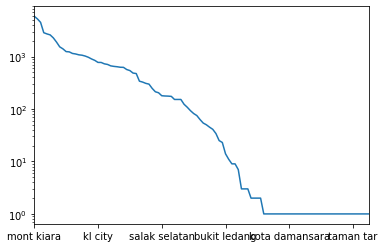

In [220]:
properties["Location"].value_counts().plot(logy=True);

In [221]:
significant_locations = properties["Location"].value_counts()[
    properties["Location"].value_counts() >= 100].index

properties = properties.loc[np.isin(properties["Location"], significant_locations)]

A new look at the locations shows that there are no more ambiguous names.

In [224]:
sorted(properties["Location"].unique())

['ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit bintang',
 'bukit jalil',
 'bukit tunku (kenny hills)',
 'cheras',
 'city centre',
 'country heights damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'dutamas',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kuchai lama',
 'mont kiara',
 'oug',
 'pandan perdana',
 'pantai',
 'salak selatan',
 'segambut',
 'sentul',
 'seputeh',
 'setapak',
 'setiawangsa',
 'sri hartamas',
 'sri petaling',
 'sungai besi',
 'sunway spk',
 'taman desa',
 'taman melawati',
 'taman tun dr ismail',
 'titiwangsa',
 'wangsa maju']

## Number of Rooms
The number of rooms contains some irregularities. For example, it is common for rooms to be listed as N+M instead of the total number of rooms. I want to clean the `Rooms` column and introduce a numerical equivalent.

In [236]:
sorted(properties["Rooms"].unique().astype(str))

['1',
 '1+1',
 '1+2',
 '10',
 '10+',
 '10+1',
 '11',
 '11+1',
 '12',
 '12+',
 '13',
 '13+',
 '13+1',
 '14',
 '15+',
 '16',
 '18',
 '2',
 '2+1',
 '2+2',
 '20 Above',
 '3',
 '3+1',
 '3+2',
 '4',
 '4+1',
 '4+2',
 '5',
 '5+1',
 '5+2',
 '6',
 '6+',
 '6+1',
 '7',
 '7+',
 '7+1',
 '8',
 '8+',
 '8+1',
 '9',
 '9+',
 '9+1',
 'Studio',
 'nan']

In [237]:
def convert_room_num(rooms):
    try:
        if rooms.endswith("+"):
            return int(rooms[:-1])
        if re.search("[0-9]+\+[0-9]+", rooms) is not None:
            tmp = rooms.split("+")
            return int(tmp[0]) + int(tmp[1])
        if rooms == "20 Above":
            return 20
        if rooms == "Studio":
            return 1
        return int(rooms)
    except AttributeError:
        return rooms

properties["Rooms_num"] = properties["Rooms"].apply(convert_room_num)

In [238]:
sorted(properties["Rooms_num"].unique())

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 nan,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 18.0,
 20.0]

# Property Type
There are several different property types that are typical for Malaysia. A brief glance at the full list  of property types seems overwhelming at first.

In [239]:
properties["Property Type"].value_counts()

Condominium                                  11447
Serviced Residence                            7176
Condominium (Corner)                          5687
Condominium (Intermediate)                    5113
Serviced Residence (Intermediate)             3255
Serviced Residence (Corner)                   2371
2-sty Terrace/Link House (Intermediate)       2361
Bungalow                                      1666
2-sty Terrace/Link House                       981
3-sty Terrace/Link House (Intermediate)        928
Bungalow (Intermediate)                        927
Semi-detached House (Intermediate)             887
Semi-detached House                            821
Bungalow (Corner)                              673
Apartment                                      672
Apartment (Intermediate)                       647
1-sty Terrace/Link House (Intermediate)        488
2-sty Terrace/Link House (Corner)              457
2.5-sty Terrace/Link House (Intermediate)      444
Residential Land               

We can greatly simplify the property types, however, by trimming information. For example, there are many different variations of the Terrace/Link houses that we can group together.

In [333]:
def simplify_property_type(prop_type):
    super_types = [
        "Terrace/Link House", "Serviced Residence", "Condominium", 
        "Semi-detached House", "Bungalow", "Apartment", "Townhouse", 
        "Flat", "Residential Land", "Cluster House"]
    for super_type in super_types:
        if re.search(super_type, prop_type, flags=re.IGNORECASE) is not None:
            return super_type
    
    return prop_type

properties["Property Type Supergroup A"] = properties["Property Type"].apply(simplify_property_type)
properties["Property Type Supergroup B"] = properties["Property Type"].str.extract("\((.*)\)").values

## Furnishing
The furnishing column thankfully doesn't require any cleaning.

In [340]:
properties["Furnishing"].value_counts()

Partly Furnished    26222
Fully Furnished     13846
Unfurnished          5611
Unknown               583
Name: Furnishing, dtype: int64

## Size
The size apparently always has the same structure:

    [Built-up/Land area] : [Value] sq. ft.

In [341]:
properties[["Size"]].sample(25)

,Size
52504,"Built-up : 1,500 sq. ft."
50250,"Built-up : 1,076 sq. ft."
53433,"Built-up : 2,128 sq. ft."
28544,"Built-up : 1,295 sq. ft."
32697,Land area : 3014 sq. ft.
48754,"Built-up : 1,150 sq. ft."
32085,Land area : 20x100 sq. ft.
31202,Built-up : 505 sq. ft.
45715,Built-up : 589 sq. ft.
10260,Built-up : 950 sq. ft.


So I will create two new column that indicate whether this is built-up or land area and store the actual square footage.

In [431]:
def split_size(val, index=0):
    try:
        return val.split(":")[index].strip()
    except AttributeError:
        return val
    
properties["Size Type"] = properties["Size"].apply(split_size, index=0)
properties["Size_num"] = properties["Size"].apply(split_size, index=1)

Now I need to strip the new `Size_num` column and convert it to a numerical value.

In [432]:
def convert_size_num(size):
    # Attempt to trim the numbers down. This is done explicitly without
    # regex to avoid incorrect trimming, which would lead to the concatenation
    # of numbers. I would rather have missing values than incorrectly cleaned
    # numbers.
    try:
        # If it's not in square feet then I don't want to deal with all
        # possible conversions for now
        if re.search(r"sq\.*\s*ft\.*", size) is None:
            return None
    
        size = size.replace(",", "")
        size = size.replace("'", "")
        size = size.replace("sq. ft.", "")
        size = size.replace("sf", "")
        size = size.strip()
        size = size.lower()
        
        add_mult_match = re.search(r"(\d+)\s*\+\s*(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if add_mult_match is not None:
            return int(add_mult_match.groups()[0]) + (
                int(add_mult_match.groups()[1]) * 
                int(add_mult_match.groups()[2]))
        
        mult_match = re.search(r"(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if mult_match is not None:
            return int(mult_match.groups()[0]) * int(mult_match.groups()[1])
        
        return int(size)
    # If any of the above doesn't work, just turn it into None/NaN
    # We want to guarantee this column is numeric
    except:
        return None
        
properties["Size_num"] = properties["Size_num"].apply(convert_size_num)

# TODO: Make co-occurrence table of NA values for original Size and Size_num to show how many values couldn't be converted!

In [433]:
properties["Size"][properties["Size_num"].isna()]

220                                           NaN
239                                           NaN
288                                           NaN
304                                           NaN
348                                           NaN
351                                           NaN
365              Land area : 646sf~1001sf sq. ft.
380                                           NaN
386              Land area : 850sf~1000sf sq. ft.
391      Land area : 22&#8217;x100&#8217; sq. ft.
392                  Land area : 850-1000 sq. ft.
501                                           NaN
538                                           NaN
568                                           NaN
621                                           NaN
711                                           NaN
770                                           NaN
780                                           NaN
806                                           NaN
849                                           NaN
